In [1]:
import sys
from comet_ml import Experiment
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary

# Local imports
sys.path.append("/Users/leo/Programming/Thesis/utils")
sys.path.append("/Users/leo/Programming/Thesis/models")

from helper_functions import (delete_ds_store,plot_metrics,test,train,mean_std_finder,load_model)
from MBNV3 import MBNV3_Creator
from CBAM import _CBAM
from config import comet_token, project_name, workspace
from torchvision.models import (mobilenet_v3_small, MobileNet_V3_Small_Weights as weights_small)

# Setting the seed for reproducibility
torch.manual_seed(42)

In [2]:
prms = {
    "backbone": mobilenet_v3_small,
    "weights": None,
    "module": _CBAM,
    "module_alias": "CBAM",
    "data_path": "/Users/leo/Programming/Thesis/data/vgg_50/",
    "batch_size": 32,
    "img_size": 224,
    "num_classes": 50,
    "epochs": 50,
    "learning_rate": 0.001,
    "device": "mps",
    "model": None,
    "experiment": Experiment(api_key=comet_token, project_name=project_name, workspace=workspace, log_code=True),
    "load_model": False,
}
prms["model_save_path"] = f"./saved_weights/{prms['module_alias']}_{prms['data_path'].split('/')[-2]}.pth"

model = prms["model"] = MBNV3_Creator(prms["num_classes"], prms["device"], prms["module"])
delete_ds_store(prms["data_path"])

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/leothesouthafrican/test/a39d3c7ac65d4da58ae9da1f2f14e20b



In [3]:
#mean, std = mean_std_finder(prms["data_path"])
mean, std = torch.tensor([0.5235, 0.4358, 0.3905]), torch.tensor([0.2993, 0.2770, 0.2729])

train_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

mean and std: 
 tensor([0.5216, 0.4358, 0.3913]) tensor([0.2983, 0.2787, 0.2754])
Mean: tensor([0.5216, 0.4358, 0.3913]), Std: tensor([0.2983, 0.2787, 0.2754])


In [4]:
#Accessing the data
train_data = torchvision.datasets.ImageFolder(prms["data_path"] + "train/", transform=train_transform)
val_data = torchvision.datasets.ImageFolder(prms["data_path"] + "val/", transform=test_transform)
test_data = torchvision.datasets.ImageFolder(prms["data_path"] + "test/", transform=test_transform)

#Creating the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=prms["batch_size"], shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


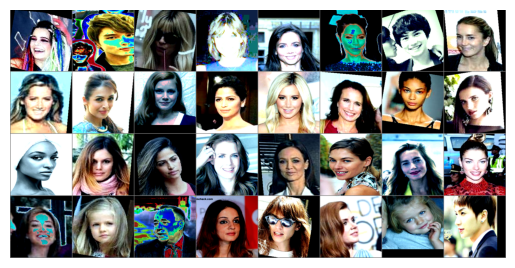

In [5]:
#display random images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
#build the model
model.build_model()
model = prms["model"].to(prms["device"])


# Loss and optimizer
criterion = nn.CrossEntropyLoss().to(prms["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=prms["learning_rate"])
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 40], gamma=0.1)

prms["experiment"].log_parameters({"loss": criterion, "optimizer": optimizer}) if prms["experiment"] else None

Model modified with custom module: <class 'CBAM._CBAM'> in layers: [1, 4, 5, 6, 7, 8, 9, 10, 11].
Model weights initialized with Xavier initialization.


In [7]:
summary(model, input_size=(1, 3, prms["img_size"], prms["img_size"]),
        col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds", "trainable"],
        col_width = 20,
        row_settings = ["var_names"],
        depth=8)

/Users/leo/Programming/Thesis/thesis_env/lib/python3.9/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds            Trainable
MBNV3_Creator (MBNV3_Creator)                                     [1, 3, 224, 224]     [1, 50]              --                   --                   --                   True
├─MobileNetV3 (model)                                             [1, 3, 224, 224]     [1, 50]              --                   --                   --                   True
│    └─Sequential (features)                                      [1, 3, 224, 224]     [1, 576, 7, 7]       --                   --                   --                   True
│    │    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 16, 112, 112]    --                   --                   --                   True
│    │    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 16, 112, 112]    432    

In [8]:
#train the model
train_losses, train_acc, val_losses, val_acc = train(model, train_loader, val_loader, criterion, optimizer, scheduler, hyper_params = prms, verbose = 2, test_transform = train_transform, experiment=prms["experiment"])

#plot the training and validation metrics
plot_metrics(train_losses, train_acc, val_losses, val_acc)

 31%|███       | 231/741 [00:48<01:49,  4.67it/s]

In [ ]:
#test the model
test(model, test_loader, criterion, hyper_params = prms, experiment = prms["experiment"])

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/leothesouthafrican/test/6f70a048bb9d4d1980ae997b7f6adfed
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     inference_time  : 0.0032291083260893336
COMET INFO:     test_accuracy   : 0.8739079833030701
COMET INFO:     test_loss       : 0.5363347019974997
COMET INFO:     total_params    : 1272766
COMET INFO:     train_acc [50]  : (0.12013573944568634, 0.9736638069152832)
COMET INFO:     train_loss [50] : (0.08667545782182372, 3.338481649760279)
COMET INFO:     val_acc [50]    : (0.19299288094043732, 0.853919267654419)
COMET INFO:     val_loss [50]   : (0.6407512271657338, 3.2186342225788325)
COMET INFO:   Parameters:
COMET 

Test loss: 0.536.. 
Test accuracy: 0.874
Test Time: 0.0m 11s 88ms


COMET INFO: Using '/Users/leo/Desktop/Thesis/notebooks/.cometml-runs' path as offline directory. Pass 'offline_directory' parameter into constructor or set the 'COMET_OFFLINE_DIRECTORY' environment variable to manually choose where to store offline experiment archives.
COMET WARNING: Could not send live data to Comet during experiment runtime. An offline experiment will be available for upload:
    comet upload --force-reupload /Users/leo/Desktop/Thesis/notebooks/.cometml-runs/6f70a048bb9d4d1980ae997b7f6adfed-TIUDkF.zip


(0.5363347019974997, tensor(0.8739, device='mps:0'))